使用 BPE 分词 (fr)，词表大小: 8000
已找到模型: spm_lm_fr_8000.model
Epoch 1: Train Loss=3.6239, Train Acc=0.3647, Valid Loss=3.1566, Valid Acc=0.3941
Epoch 2: Train Loss=3.0090, Train Acc=0.4062, Valid Loss=2.9545, Valid Acc=0.4140
Epoch 3: Train Loss=2.7986, Train Acc=0.4210, Valid Loss=2.8589, Valid Acc=0.4232
Epoch 4: Train Loss=2.6470, Train Acc=0.4332, Valid Loss=2.8093, Valid Acc=0.4282
Epoch 5: Train Loss=2.5270, Train Acc=0.4430, Valid Loss=2.7961, Valid Acc=0.4348


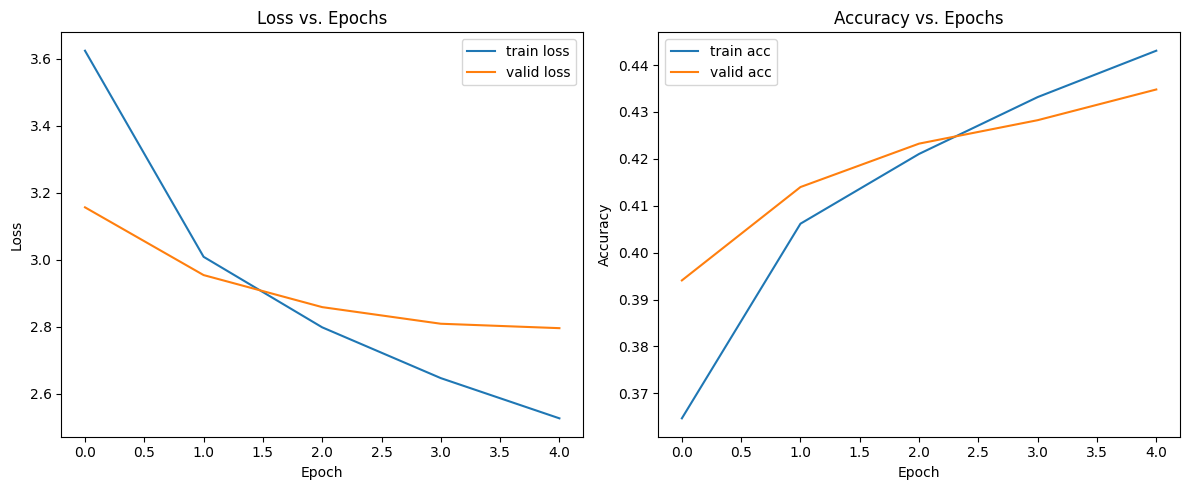


最终测试集损失 (Final Test Loss): 3.1797, 最终测试集准确率 (Test Acc): 0.3889

[原文]  une paire de pieds avec des chaussettes sont près d&apos; un feu dans un baril .
[ID序列]  [1, 16, 3454, 13, 1071, 57, 54, 2698, 143, 265, 6, 7983, 27, 7982, 5, 713, 48, 5, 3847, 10, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] ...
[分词(BPE)]  ['<s>', '▁une', '▁paire', '▁de', '▁pieds', '▁avec', '▁des', '▁chaussettes', '▁sont', '▁près', '▁d', '&', 'apos', ';', '▁un', '▁feu', '▁dans', '▁un', '▁baril', '▁.', '</s>']

=== 随机文本生成示例 (Generation Examples) ===
提示 (Prompt): 'deux jeunes filles ,'
参考 (Original): deux jeunes filles , l&apos; une sur un petit vélo , l&apos; autre sur un petit tricycle , dans un endroit avec du sable .
生成 (Generated): deux jeunes filles , l&apos; un en noir , l&apos; autre en t-shirt rouge et l&apos; autre en t-shirt rouge , l&apos; autre en t-shirt rouge et l&apos;
----------------------------------------
提示 (Prompt): 'une voiture'
参考 (Original): une voiture de sport noire avec une 

In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Decoder-Only Transformer 语言模型实验
Task-3 子任务2：实现 Transformer 基础结构 (Decoder-Only 变种)
"""

import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import sentencepiece as spm
import random
from collections import Counter

# ========== 宏定义参数 (Hyperparameters) ==========
PARAMS = {
    # --- 核心模型架构选择 ---
    "LANG": "fr",                  # 选择语言 'de' 或 'fr'

    # --- 分词器和词表 ---
    "TOKENIZER_TYPE": "bpe",       # 可选 "word", "bpe", 或 "char"
    "VOCAB_SIZE": 8000,            # 控制词级别和BPE的词表大小
    "MODEL_PREFIX": "spm_lm",      # BPE模型文件前缀

    # --- 模型和训练参数 ---
    "MAX_LEN": 50,
    "BATCH_SIZE": 32,
    "EMBED_DIM": 128,
    "NHEAD": 4,
    "NUM_LAYERS": 2,
    "LR": 1e-3,
    "EPOCHS": 5,
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu",
}

# --- 数据文件路径 ---
DATA_DIR = "data/de_fr"
# ... (如果文件夹不存在，则创建)
if not os.path.exists(DATA_DIR):
    print(f"警告：数据文件夹 {DATA_DIR} 不存在。请创建并放入数据文件。")
    os.makedirs(DATA_DIR, exist_ok=True)
    dummy_files = ["train.de", "train.fr", "val.de", "val.fr", "test.de", "test.fr"]
    for fname in dummy_files:
        with open(os.path.join(DATA_DIR, fname), "w", encoding="utf-8") as f:
            f.write("ein beispiel satz .\n")
            f.write("ein anderer beispiel satz .\n")

# 根据选择的语言确定语料路径
TRAIN_FILE = os.path.join(DATA_DIR, f"train.{PARAMS['LANG']}")
VALID_FILE = os.path.join(DATA_DIR, f"val.{PARAMS['LANG']}")
TEST_FILE = os.path.join(DATA_DIR, f"test.{PARAMS['LANG']}")


# ========== 数据读取 & 工具函数 ==========
def load_mono_corpus(file):
    """读取单语语料库"""
    try:
        with open(file, encoding="utf-8") as f:
            lines = [line.strip() for line in f if line.strip()]
        return lines
    except FileNotFoundError:
        print(f"错误: 文件 {file} 未找到。")
        return []

def calculate_accuracy(pred, target, pad_idx=0):
    """计算Token级别准确率，忽略padding部分"""
    pred_tokens = pred.argmax(dim=-1)
    correct_mask = (pred_tokens == target)
    pad_mask = (target != pad_idx)
    correct_tokens = (correct_mask & pad_mask).sum().float()
    total_tokens = pad_mask.sum().float()
    return (correct_tokens / total_tokens).item() if total_tokens > 0 else 0


# ========== Tokenizer ==========
class BPETokenizer:
    def __init__(self, model_file): self.sp = spm.SentencePieceProcessor(); self.sp.load(model_file)
    def encode(self, text, max_len=None):
        ids = [1] + self.sp.encode(text, out_type=int) + [2];
        if max_len: ids = (ids + [0] * (max_len - len(ids)))[:max_len]
        return ids
    def decode(self, ids): return self.sp.decode([i for i in ids if i not in (0, 1, 2)])
    def vocab_size(self): return self.sp.get_piece_size()

class SimpleTokenizer:
    def __init__(self, vocab):
        self.word2idx = {word: i for i, word in enumerate(vocab, start=4)}; self.word2idx.update({"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3})
        self.idx2word = {i: word for word, i in self.word2idx.items()}
    def encode(self, text, max_len=None):
        ids = [1] + [self.word2idx.get(w, 3) for w in text.split()] + [2];
        if max_len: ids = (ids + [0] * (max_len - len(ids)))[:max_len]
        return ids
    def decode(self, ids): return " ".join([self.idx2word.get(i, "<unk>") for i in ids if i not in (0, 1, 2)])
    def vocab_size(self): return len(self.word2idx)

class CharTokenizer:
    def __init__(self, vocab):
        self.char2idx = {char: i for i, char in enumerate(vocab, start=4)}; self.char2idx.update({"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3})
        self.idx2char = {i: char for char, i in self.char2idx.items()}
    def encode(self, text, max_len=None):
        ids = [1] + [self.char2idx.get(c, 3) for c in text] + [2];
        if max_len: ids = (ids + [0] * (max_len - len(ids)))[:max_len]
        return ids
    def decode(self, ids): return "".join([self.idx2char.get(i, "") for i in ids if i not in (0, 1, 2)])
    def vocab_size(self): return len(self.char2idx)


# ========== Dataset ==========
class LanguageModelDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data, self.tokenizer, self.max_len = data, tokenizer, max_len
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        text = self.data[idx];
        ids = self.tokenizer.encode(text, self.max_len)
        return torch.tensor(ids)


# ========== 模型架构 ==========
class TransformerLM(nn.Module):
    """Decoder-Only 语言模型"""
    def __init__(self, vocab_size, embed_dim, nhead, num_layers):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = nn.Embedding(PARAMS["MAX_LEN"] + 1, embed_dim) # 使用MAX_LEN定义位置编码
        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_dim, nhead=nhead, batch_first=True)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(embed_dim, vocab_size)

    def forward(self, tgt):
        device, tgt_len = tgt.device, tgt.size(1)
        tgt_padding_mask = (tgt == 0)
        tgt_pos = torch.arange(0, tgt_len, device=device).unsqueeze(0)
        tgt_embedded = self.token_emb(tgt) + self.pos_encoder(tgt_pos)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_len).to(device)
        
        # Decoder-Only模型中，memory等于tgt_embedded
        out = self.transformer_decoder(tgt=tgt_embedded, memory=tgt_embedded, 
                                     tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_padding_mask,
                                     memory_mask=tgt_mask, memory_key_padding_mask=tgt_padding_mask)
        return self.fc_out(out)


# ========== 训练与验证 ==========
def train_model(model, train_loader, valid_loader, optimizer, criterion, epochs, device):
    train_losses, valid_losses, train_accs, valid_accs = [], [], [], []
    for epoch in range(epochs):
        model.train()
        total_loss, total_acc = 0, 0
        for tgt in train_loader:
            tgt = tgt.to(device)
            tgt_input, tgt_output = tgt[:, :-1], tgt[:, 1:]
            
            optimizer.zero_grad()
            output = model(tgt_input)
            loss = criterion(output.reshape(-1, output.size(-1)), tgt_output.reshape(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_acc += calculate_accuracy(output, tgt_output)

        avg_train_loss, avg_train_acc = total_loss/len(train_loader), total_acc/len(train_loader)
        avg_valid_loss, avg_valid_acc = evaluate(model, valid_loader, criterion, device)
        train_losses.append(avg_train_loss); valid_losses.append(avg_valid_loss)
        train_accs.append(avg_train_acc); valid_accs.append(avg_valid_acc)
        print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Train Acc={avg_train_acc:.4f}, "
              f"Valid Loss={avg_valid_loss:.4f}, Valid Acc={avg_valid_acc:.4f}")
    return train_losses, valid_losses, train_accs, valid_accs

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, total_acc = 0, 0
    with torch.no_grad():
        for tgt in loader:
            tgt = tgt.to(device)
            tgt_input, tgt_output = tgt[:, :-1], tgt[:, 1:]
            output = model(tgt_input)
            loss = criterion(output.reshape(-1, output.size(-1)), tgt_output.reshape(-1))
            total_loss += loss.item()
            total_acc += calculate_accuracy(output, tgt_output)
    return total_loss / len(loader), total_acc / len(loader)


# ========== 推理与结果展示 ==========
def generate_text(model, tokenizer, prompt, max_len, device):
    """让语言模型根据提示生成文本"""
    model.eval()
    prompt_ids = tokenizer.encode(prompt, max_len=None)[:-1] # 移除prompt自带的<eos>
    ys = torch.tensor([prompt_ids], device=device)
    eos_id = 2
    for _ in range(max_len - len(prompt_ids)):
        with torch.no_grad():
            output = model(ys)
            next_word_logits = output[:, -1, :]
            next_word = next_word_logits.argmax(dim=-1).item()
        ys = torch.cat([ys, torch.tensor([[next_word]], device=device)], dim=1)
        if next_word == eos_id: break
    return tokenizer.decode(ys[0].tolist())

def show_generations(model, tokenizer, data, n, device):
    """展示语言模型的文本生成样本"""
    if not data: return
    print("\n=== 随机文本生成示例 (Generation Examples) ===")
    samples = random.sample(data, min(n, len(data)))
    for text in samples:
        # 根据分词方式选择合适的prompt长度
        if PARAMS["TOKENIZER_TYPE"] == 'char': 
            prompt = text[:random.randint(5, 10)] # 字符级取前5-10个字符
        else:
            prompt_words = text.split()
            prompt = " ".join(prompt_words[:random.randint(2, 4)]) # 词/BPE级取前2-4个词
        
        if not prompt: continue # 避免空prompt

        pred = generate_text(model, tokenizer, prompt, PARAMS["MAX_LEN"], device)
        print(f"提示 (Prompt): '{prompt}'\n参考 (Original): {text}\n生成 (Generated): {pred}\n" + "-"*40)

def show_tokenization_example(tokenizer, data, max_len):
    """展示单个语言的分词效果"""
    if not data: return
    text = random.choice(data)
    ids = tokenizer.encode(text, max_len)
    print(f"\n[原文]  {text}")
    print(f"[ID序列]  {ids[:40]} ...")
    
    if isinstance(tokenizer, BPETokenizer):
        print("[分词(BPE)] ", [tokenizer.sp.id_to_piece(i) for i in ids if i != 0][:40])
    elif isinstance(tokenizer, SimpleTokenizer):
        print("[分词(Word)] ", [tokenizer.idx2word.get(i, "<unk>") for i in ids if i != 0][:40])
    elif isinstance(tokenizer, CharTokenizer):
        print("[分词(Char)] ", [tokenizer.idx2char.get(i, "<unk>") for i in ids if i != 0][:40])


# ========== BPE 训练 & 词汇表构建 ==========
def train_sentencepiece(input_file, model_prefix, vocab_size=10000, model_type="bpe"):
    model_path_prefix = f"{model_prefix}_{PARAMS['LANG']}_{vocab_size}"
    model_file = model_path_prefix + ".model"
    if not os.path.exists(model_file):
        print(f"训练SentencePiece模型: {model_path_prefix}，词表大小 {vocab_size}")
        spm.SentencePieceTrainer.Train(
            f"--input={input_file} --model_prefix={model_path_prefix} "
            f"--vocab_size={vocab_size} --model_type={model_type} "
            f"--bos_id=1 --eos_id=2 --unk_id=3 --pad_id=0"
        )
    else: print(f"已找到模型: {model_file}")
    return model_file

def build_vocab(corpus, level='word', vocab_size=10000):
    if level == 'word':
        word_freq = Counter(word for sentence in corpus for word in sentence.split())
        most_common_words = [word for word, freq in word_freq.most_common(vocab_size - 4)]
        print(f"从 {len(word_freq)} 个独立单词中，构建了大小为 {len(most_common_words)} 的词汇表。")
        return sorted(most_common_words)
    elif level == 'char':
        tokens = sorted(list(set(char for sentence in corpus for char in sentence)))
        print(f"构建了大小为 {len(tokens)} 的字符级词汇表。")
        return tokens


# ========== 主程序 (Main Program) ==========
def main():
    train_data = load_mono_corpus(TRAIN_FILE)
    valid_data = load_mono_corpus(VALID_FILE)
    test_data = load_mono_corpus(TEST_FILE)
    if not train_data: print("训练数据为空，程序终止。请检查数据文件路径和内容。"); return
    
    # 初始化分词器
    if PARAMS["TOKENIZER_TYPE"] == "bpe":
        print(f"使用 BPE 分词 ({PARAMS['LANG']})，词表大小: {PARAMS['VOCAB_SIZE']}")
        model_file = train_sentencepiece(TRAIN_FILE, PARAMS["MODEL_PREFIX"], PARAMS["VOCAB_SIZE"])
        tokenizer = BPETokenizer(model_file)
    elif PARAMS["TOKENIZER_TYPE"] == "char":
        print(f"使用字符级分词 ({PARAMS['LANG']})")
        vocab = build_vocab(train_data, level='char')
        tokenizer = CharTokenizer(vocab)
    else: # 默认为 "word"
        print(f"使用词级分词 ({PARAMS['LANG']})，词表大小: {PARAMS['VOCAB_SIZE']}")
        vocab = build_vocab(train_data, 'word', PARAMS['VOCAB_SIZE'])
        tokenizer = SimpleTokenizer(vocab)
    
    # 创建Dataset和DataLoader
    train_dataset = LanguageModelDataset(train_data, tokenizer, PARAMS["MAX_LEN"])
    valid_dataset = LanguageModelDataset(valid_data, tokenizer, PARAMS["MAX_LEN"])
    test_dataset = LanguageModelDataset(test_data, tokenizer, PARAMS["MAX_LEN"])
    train_loader = DataLoader(train_dataset, batch_size=PARAMS["BATCH_SIZE"], shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=PARAMS["BATCH_SIZE"])
    test_loader = DataLoader(test_dataset, batch_size=PARAMS["BATCH_SIZE"])

    # 初始化模型、优化器和损失函数
    model = TransformerLM(tokenizer.vocab_size(), PARAMS["EMBED_DIM"], PARAMS["NHEAD"], PARAMS["NUM_LAYERS"]).to(PARAMS["DEVICE"])
    optimizer = torch.optim.Adam(model.parameters(), lr=PARAMS["LR"])
    criterion = nn.CrossEntropyLoss(ignore_index=0)

    # 训练模型
    train_losses, valid_losses, train_accs, valid_accs = train_model(model, train_loader, valid_loader, optimizer, criterion, PARAMS["EPOCHS"], PARAMS["DEVICE"])

    # 可视化结果
    plt.figure(figsize=(12, 5)); plt.subplot(1, 2, 1); plt.plot(train_losses, label="train loss"); plt.plot(valid_losses, label="valid loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss vs. Epochs")
    plt.subplot(1, 2, 2); plt.plot(train_accs, label="train acc"); plt.plot(valid_accs, label="valid acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy vs. Epochs")
    plt.tight_layout(); plt.show()

    # 在测试集上评估并展示结果
    test_loss, test_acc = evaluate(model, test_loader, criterion, PARAMS["DEVICE"])
    print(f"\n最终测试集损失 (Final Test Loss): {test_loss:.4f}, 最终测试集准确率 (Test Acc): {test_acc:.4f}")

    show_tokenization_example(tokenizer, test_data, PARAMS["MAX_LEN"])
    show_generations(model, tokenizer, test_data, n=10, device=PARAMS["DEVICE"])

if __name__ == "__main__":
    main()


In [2]:
import sentencepiece as spm

# 加载训练好的模型
src_sp = spm.SentencePieceProcessor(model_file="spm_de.model")
tgt_sp = spm.SentencePieceProcessor(model_file="spm_fr.model")

# 测试德语
text_de = "Ich liebe dich"
ids_de = src_sp.encode(text_de, out_type=int)
back_de = src_sp.decode(ids_de)

print("德语原文:", text_de)
print("编码后的ID:", ids_de)
print("解码回文本:", back_de)

# 测试法语
text_fr = "Je t'aime beaucoup"
ids_fr = tgt_sp.encode(text_fr, out_type=int)
back_fr = tgt_sp.decode(ids_fr)

print("\n法语原文:", text_fr)
print("编码后的ID:", ids_fr)
print("解码回文本:", back_fr)


德语原文: Ich liebe dich
编码后的ID: [9965, 3, 10, 8352, 17, 69]
解码回文本:  ⁇ ch liebe dich

法语原文: Je t'aime beaucoup
编码后的ID: [9960, 3, 9961, 22, 3, 846, 368, 837]
解码回文本:  ⁇ e t ⁇ aime beaucoup


In [3]:
import sentencepiece as spm

class BPETokenizer:
    def __init__(self, model_file):
        self.sp = spm.SentencePieceProcessor(model_file=model_file)

    def encode(self, text):
        return [1] + self.sp.encode(text, out_type=int) + [2]  # <sos>=1, <eos>=2

    def decode(self, ids):
        if ids and ids[0] == 1:
            ids = ids[1:]
        if ids and ids[-1] == 2:
            ids = ids[:-1]
        return self.sp.decode(ids)

    def vocab_size(self):
        return self.sp.get_piece_size()

    def subwords(self, text):
        pieces = self.sp.encode(text, out_type=str)
        print(f"\n[Subword 切分] 输入: {text}")
        print("切分结果:", pieces)
        return pieces


if __name__ == "__main__":
    # 加载你训练好的 SentencePiece 模型
    src_tok = BPETokenizer("spm_de.model")  # 德语模型
    tgt_tok = BPETokenizer("spm_fr.model")  # 法语模型

    # 测试样例
    test_sentences_de = [
        "Das ist unglaublich.",
        "Ein unbekanntes Wort.",
        "Wir lernen maschinelle Übersetzung."
    ]

    test_sentences_fr = [
        "Ceci est incroyable.",
        "Un mot inconnu.",
        "Nous apprenons la traduction automatique."
    ]

    print("===== 德语分词 =====")
    for s in test_sentences_de:
        src_tok.subwords(s)

    print("\n===== 法语分词 =====")
    for s in test_sentences_fr:
        tgt_tok.subwords(s)


===== 德语分词 =====

[Subword 切分] 输入: Das ist unglaublich.
切分结果: ['▁', 'D', 'as', '▁ist', '▁ungl', 'aub', 'lich', '.']

[Subword 切分] 输入: Ein unbekanntes Wort.
切分结果: ['▁', 'E', 'in', '▁unbekann', 'tes', '▁', 'W', 'ort', '.']

[Subword 切分] 输入: Wir lernen maschinelle Übersetzung.
切分结果: ['▁', 'W', 'ir', '▁lernen', '▁maschine', 'lle', '▁', 'Ü', 'b', 'ers', 'etz', 'ung', '.']

===== 法语分词 =====

[Subword 切分] 输入: Ceci est incroyable.
切分结果: ['▁', 'C', 'e', 'ci', '▁est', '▁incroyable', '.']

[Subword 切分] 输入: Un mot inconnu.
切分结果: ['▁', 'U', 'n', '▁mot', '▁inconnu', '.']

[Subword 切分] 输入: Nous apprenons la traduction automatique.
切分结果: ['▁', 'N', 'ous', '▁appr', 'en', 'ons', '▁la', '▁trad', 'uction', '▁automatique', '.']
